<a href="https://colab.research.google.com/github/sreenesh-reddy/Infosys-Springboard-Internship/blob/main/Lesnet_HandwrittenDigitRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing PyTorch, a library for building and training machine learning models
import torch

# Importing modules for defining neural network layers and architectures
import torch.nn as nn

# Importing optimization module to adjust weights during training
import torch.optim as optim

# Importing torchvision for working with datasets and applying transformations
from torchvision import datasets, transforms

# Importing DataLoader to handle batching and shuffling of datasets
from torch.utils.data import DataLoader

# Importing matplotlib for plotting and visualizing data
import matplotlib.pyplot as plt


In [2]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors (from [0, 255] to [0, 1])
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(
    root='./data',            # Directory to store the data
    train=True,               # Load the training set
    download=True,            # Download the dataset if not already downloaded
    transform=transform       # Apply the transformations defined above
)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',            # Directory to store the data
    train=False,              # Load the test set
    download=True,            # Download the dataset if not already downloaded
    transform=transform       # Apply the transformations defined above
)

# Create a DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,            # Dataset to load
    batch_size=64,            # Number of images per batch
    shuffle=True              # Shuffle the data for better training
)

# Create a DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset,             # Dataset to load
    batch_size=64,            # Number of images per batch
    shuffle=False             # No need to shuffle test data
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.96MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Define the LeNet-5 model architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Define the first convolutional layer:
        # Input: 1 channel (grayscale), Output: 6 channels (feature maps), kernel size = 5, stride = 1, padding = 2 (to maintain size)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # Output: 6x28x28

        # Define average pooling layer with kernel size of 2 and stride of 2
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: 6x14x14 after pooling

        # Define the second convolutional layer:
        # Input: 6 channels, Output: 16 channels, kernel size = 5, stride = 1
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Output: 16x10x10

        # Fully connected layer with 16 * 5 * 5 input features and 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # Second fully connected layer with 120 input features and 84 output features
        self.fc2 = nn.Linear(120, 84)

        # Third fully connected layer with 84 input features and 10 output features (for 10 classes)
        self.fc3 = nn.Linear(84, 10)

        # ReLU activation function to apply non-linearity
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply first convolution + ReLU activation
        x = self.relu(self.conv1(x))

        # Apply pooling after the first convolution
        x = self.pool(x)

        # Apply second convolution + ReLU activation
        x = self.relu(self.conv2(x))

        # Apply pooling after the second convolution
        x = self.pool(x)

        # Flatten the output to prepare for the fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer + ReLU activation
        x = self.relu(self.fc1(x))

        # Apply second fully connected layer + ReLU activation
        x = self.relu(self.fc2(x))

        # Apply the final fully connected layer (output layer)
        x = self.fc3(x)

        # Return the raw scores for each class (no softmax yet, because we use CrossEntropyLoss which applies it internally)
        return x

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if GPU is available
model = LeNet5().to(device)  # Move model to the device (CPU or GPU)

# CrossEntropyLoss combines softmax and negative log-likelihood loss in one step
criterion = nn.CrossEntropyLoss()

# Adam optimizer to adjust the model's weights during training
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Set the model to training mode (affects layers like dropout/batch norm)

    # Loop through each epoch
    for epoch in range(epochs):
        running_loss = 0.0  # Initialize a variable to track loss during the epoch

        # Loop through batches of images and labels in the training data
        for images, labels in train_loader:
            # Move images and labels to the correct device (GPU/CPU)
            images, labels = images.to(device), labels.to(device)

            # Forward pass: pass images through the model to get predictions
            outputs = model(images)

            # Calculate the loss using the model's outputs and true labels
            loss = criterion(outputs, labels)

            # Zero the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()

            # Backward pass: calculate gradients
            loss.backward()

            # Optimize the model's parameters using the gradients
            optimizer.step()

            # Add the loss of this batch to the running total
            running_loss += loss.item()

        # Print the average loss after each epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")


In [5]:
# Function to evaluate the model on the test data
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm, etc.)

    correct = 0  # Initialize a counter for correctly predicted labels
    total = 0    # Initialize a counter for the total number of labels

    # Disable gradient calculation, since we are not updating model parameters during evaluation
    with torch.no_grad():
        # Loop through the test data
        for images, labels in test_loader:
            # Move images and labels to the correct device (GPU/CPU)
            images, labels = images.to(device), labels.to(device)

            # Pass the images through the model to get predictions
            outputs = model(images)

            # Get the predicted class by selecting the class with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Update the total count of images processed
            total += labels.size(0)

            # Update the count of correct predictions
            correct += (predicted == labels).sum().item()

    # Print the test accuracy (percentage of correct predictions)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Train the model and evaluate its performance on the test set
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)


Epoch 1/10, Loss: 0.3301
Epoch 2/10, Loss: 0.0935
Epoch 3/10, Loss: 0.0665
Epoch 4/10, Loss: 0.0513
Epoch 5/10, Loss: 0.0423
Epoch 6/10, Loss: 0.0356
Epoch 7/10, Loss: 0.0304
Epoch 8/10, Loss: 0.0262
Epoch 9/10, Loss: 0.0244
Epoch 10/10, Loss: 0.0211
Test Accuracy: 98.81%


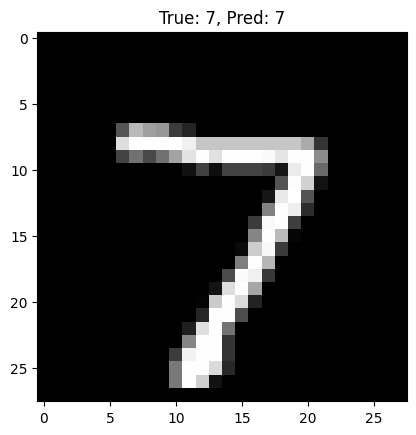

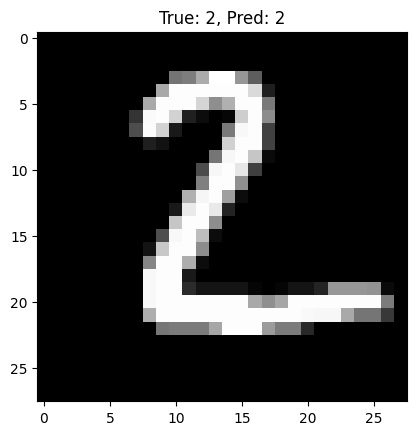

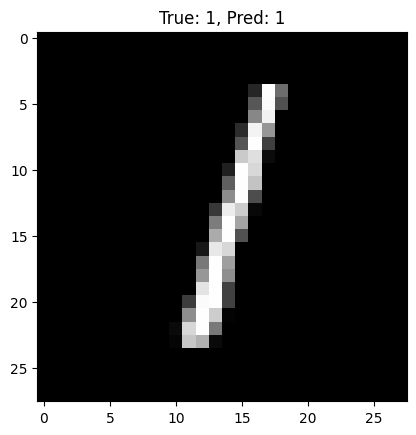

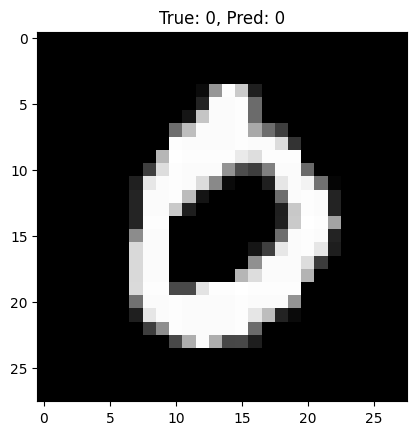

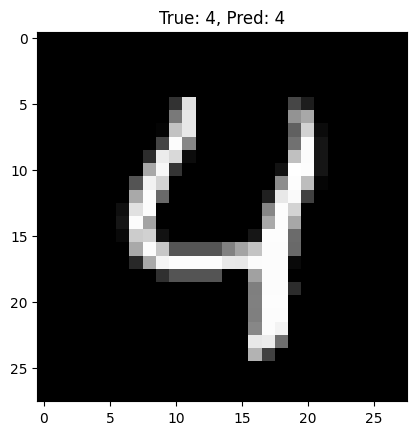

In [6]:
# Function to make predictions and visualize the results
def predict(model, test_loader, num_samples=5):
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm, etc.)

    # Get an iterator for the test_loader and fetch a batch of images and labels
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Select the first `num_samples` images and labels from the batch and move them to the correct device
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)

    # Get the model's predictions for the images
    outputs = model(images)

    # Find the predicted class by taking the class with the highest score
    _, predicted = torch.max(outputs, 1)

    # Visualize the predictions
    images = images.cpu().numpy()  # Move images back to CPU and convert to NumPy array for visualization

    # Loop through each image and display the image with its true and predicted labels
    for i in range(num_samples):
        plt.imshow(images[i][0], cmap='gray')  # Display the image in grayscale
        plt.title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")  # Show true and predicted labels in the title
        plt.show()  # Show the image

# Call the function to make predictions and visualize the results
predict(model, test_loader)


In [12]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load your pre-trained model
model.eval()
# Define the preprocessing for the custom image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure it's single channel
    transforms.Resize((28, 28)),                  # Resize to 28x28
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))          # Normalize to [-1, 1]
])

# Load your custom image
def predict_custom_image(image_path, model):
    # Open the image
    image = Image.open(image_path)

    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the tensor to the same device as the model
    image_tensor = image_tensor.to(device)

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    return predicted_label.item()

# Provide the path to your image
image_path = "/content/col.png"

# Predict the digit
predicted_digit = predict_custom_image(image_path, model)
print(f"Predicted digit: {predicted_digit}")

Predicted digit: 1
